## APPROACH:
### 1. Loading custom dataset
### 2. NLP pipeline for text preprocessing
### 3. Loading Glove embedding matrix
### 4. Converting sentences to vectors (creating the o/p of embedding layer)
### 5. Creating Keras embedding layer and feeding to biLSTM
### 6. Results visualization and comparison

In [1]:
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')

# NLP
from nltk.tokenize.regexp import RegexpTokenizer
#from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# import gensim
import spacy
import en_core_web_sm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

Using TensorFlow backend.


## Step 1: Load dataset

In [2]:
# from google.colab import files
# uploaded = files.upload()

In [7]:
# emails_df = pd.read_csv('./emails.csv', nrows=20000)
df = pd.read_csv('/home/aheli/emaildataset.csv', encoding='cp1252')
print(df.shape)
df.head()

(951, 7)


,From,To,Subject,Body,Class,TransactionID,Payment Date
0,Spike@DEUTSCHEBANK.com,Shaniece@CitiBankPune.com,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,72558,04-02-2020
1,Stacy@HDFC.com,Rohan@CitiBankNewYork.com,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,212096,29-05-2020
2,Zachary@HDFC.com,Rishabh@CitiBankPune.com,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,847047,26-01-2020
3,Stacy@SBI.com,Shai@CitiBankHongKong.com,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,746078,17-06-2019
4,Angela@HDFC.com,Dipesh@CitiBankSingapore.com,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,535918,18-02-2020


In [9]:
df.Class.unique()

array(['Pending', 'General', 'Processing', 'Request', 'Complete',
       'Failed'], dtype=object)

In [10]:
nlp_ = en_core_web_sm.load()

In [11]:
nlp = spacy.load('en')

In [12]:
def clean(text):
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = " ".join([i for i in text.lower().split()])
    print(text)
    
    customize_stop_words = ["cc","subject","http", "gbp", "usd", "eur", "inr", "cad","thanks", "acc", "id", "account", "regards", "hi", "hello", "thank you", "greetings"]
    rem_stop = ["not", "wasn't", "hadn't", "won't", "can't", "didn't"]
    
    for w in customize_stop_words:
        nlp.vocab[w].is_stop = True
    
    for w in rem_stop:
        nlp.vocab[w].is_stop = False
    
    doc = nlp(text)
    
    normalized = " ".join(token.lemma_ for token in doc if not token.is_stop)
    
    doc = " ".join(token.orth_ for token in nlp(normalized) if not token.is_punct | token.is_space)

#     exclude = set(string.punctuation) 
#     lemma = WordNetLemmatizer()
#     porter= PorterStemmer()

    # IS AMOUNT EXTRACTION  NEEDED?
    #amount = "".join([i for i in text.lower().split() if i.isdigit()])
    
#     stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
#     doc = lemma(punc_free)
    
#     normalized = " ".join(lemma(word) for token in punc_free.split())
#     stem = " ".join(porter.stem(token) for token in normalized.split())
#     return normalized, amount

#     return normalized
    return doc

In [13]:
print(clean("payment in id 1234 for amount 14859 GBP has been freezed"))

payment in id for amount gbp has been freezed
payment would freeze


In [14]:
for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text_Data'] = (df['Subject'] + " " + df['Body'])

In [15]:
def converter(x):
    try:
        return ' '.join([x.lower() for x in str(x).split()])
    except AttributeError:
        return None  # or some other value

df['Text_Data'] = df['Text_Data'].apply(converter)

In [16]:
df.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,Text_Data
0,Spike@DEUTSCHEBANK.com,Shaniece@CitiBankPune.com,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,72558,04-02-2020,transaction no. 072558 is unresolved. sorry to...
1,Stacy@HDFC.com,Rohan@CitiBankNewYork.com,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,212096,29-05-2020,"order for new cheque book good morning, i want..."
2,Zachary@HDFC.com,Rishabh@CitiBankPune.com,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,847047,26-01-2020,required money acquired. transaction 847047 is...
3,Stacy@SBI.com,Shai@CitiBankHongKong.com,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,746078,17-06-2019,asking for the details for transaction 746078 ...
4,Angela@HDFC.com,Dipesh@CitiBankSingapore.com,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,535918,18-02-2020,partial payment for transaction 535918 hello!!...


In [17]:
# sub_df["content"]=sub_df["content"].map(clean)
text_clean=[]

for i in range(df.shape[0]):
    text_clean.append(clean(df.loc[i]['Text_Data']))

# text_clean
# print(type(df.values[i][7]))

transaction no is unresolved sorry to inform that there has been only a partial payment of amount gbp you are definitely going to receive the rest at a later point of time warm regards
order for new cheque book good morning i want to place an order for an multicity cheque book for account no having atleat leaves kindly send the same to the address mentioned in my account records
required money acquired transaction is in process hello this is to inform you that i have received the amount you transferred to my account and now it is currently in process
asking for the details for transaction i request you to kindly send the status of my transaction with id thanks and regards
partial payment for transaction hello greetings for the day status of transaction usd for account is pending i would be grateful if you could tell me the cause thanks a lot
payment done and transaction settled greetings i wanted to let you know that i have acknowledged the payment for transaction in response to your e

seeking update on the status of transaction i need details of urgently please provide the same on priority basis
concluded the transaction greetings i wanted to let you know that i have acknowledged the payment for transaction in response to your email which confirmed the finalized status of my transaction thanks and regards
payment outstanding for transaction this is to regretfully inform you that i could only pay the partial amount of inr i will definitely pay the remaining amount as soon as possible thank you for understanding regards
fulfilled transaction having id i deeply appreciate your quick service as i have received the pre approved loan amount of eur
fulfilled transaction having id to whom it may concern i have successfully received payment for the transaction i am grateful for your cooperation thank you so much and regards
incomplete transaction the transaction is taking too long to complete i would request you to kindly guide me through the further steps to be taken in ord

how to create a bank account with citi i have heard a lot about your bank and would like to open an account with citibank for that i would like to know all the documents that are required kindly reply with the same and also the further steps to be taken eagerly waiting for your reply
add one more contact no to account add to my account thanks
transaction has failed this is in response to your email stating that my transaction having id has failed but no reason was mentioned can you please tell me what did i do wrong so that i can create a new one without any errors waiting for your reply thank you in advance
pending payment for transaction having id hello greetings for the day i see that transaction gbp for account is pending i would be grateful if you could tell me the cause thanks a lot
payment done and transaction settled hey i am writing in reference to the transaction i was granted the aforementioned amount within the deadline sincere gratitude for such a quick response kind regar

concluded the transaction greetings i wanted to let you know that i have acknowledged the payment for transaction in response to your email which confirmed the finalized status of my transaction thanks and regards
want to block account hey can you please block my account i no longer want to avail your services
soliciting information for id hey i would be really grateful if you could tell me the details of account no thanks
received full payment for transaction no hello sincere greetings for the day i would like to inform you that my transaction has completed thank you so much for your support looking forward to working more with you in the future regards
urgent transaction ceased i have been your regular client and have followed the procedure for creating a transaction correctly still i received an email saying that the transaction has failed i would like to know the reasoning my transaction id is regards
request to send details of transaction i need details of urgently please provide 

sorted out the transaction with id hello sincere greetings for the day i would like to inform you that my transaction has completed thank you so much for your support looking forward to working more with you in the future regards
transaction has failed this is to notify you that my transaction has failed please reply to me with the cause as soon as possible
imploring update on transaction please provide a status update on at the earliest
asking for the details for transaction i request you to kindly send the status of my transaction with id thanks and regards
concluded the transaction glad to let you know that i got the desired payment in reference to transaction i am very happy with your services and will definitely recommend your company to my friends and acquaintances warm regards
transaction is now being processed this is in response to your email notifying about the transferred amount i am acknowledging it and informing you that it is now in process
partial payment for transaction

payment done and transaction settled hey i am writing in reference to the transaction i was granted the aforementioned amount within the deadline sincere gratitude for such a quick response kind regards
send steps to activate online banking this is to inform you that i am not able to withdraw money from my account please help
finalized transaction of id glad to let you know that i got the desired payment in reference to transaction i am very happy with your services and will definitely recommend your company to my friends and acquaintances warm regards
dealing with the transaction hello this is to inform you that i have received the amount you transferred to my account and now it is currently in process
payment done and transaction settled greetings i wanted to let you know that i have acknowledged the payment for transaction in response to your email which confirmed the finalized status of my transaction thanks and regards
urgently required update on transaction i want to know status 

payment done and transaction settled i deeply appreciate your quick service as i have received the pre approved loan amount of usd
how to change pin no of atm card i would like to know the instructions to be followed to install and setup mobile banking please reply to me with the same thanks in advance
transaction no is unresolved since my transaction is still pending i wanted to know if there is a problem with the paperwork from my side please let me know at the earliest thanks and regards
remaining amount for transaction to be paid later the transaction is taking too long to complete i would request you to kindly guide me through the further steps to be taken in order to complete the transaction
why has my transaction stopped hey i see my transaction with id has failed i think i did everything right please look into this and reply with the reason urgently thank you and regards
processing transaction having id hello this is to inform you that i have received the amount you transferred

transaction is now being processed this is in response to your email notifying about the transferred amount i am acknowledging it and informing you that it is now in process
transaction has failed this is to notify you that my transaction has failed please reply to me with the cause as soon as possible
processing transaction having id acknowledging the received payment for transaction it is finally in process kind regards
partial payment for transaction since my transaction is still pending i wanted to know if there is a problem with the paperwork from my side please let me know at the earliest thanks and regards
completed transaction no hey i am writing in reference to the transaction i was granted the aforementioned amount within the deadline sincere gratitude for such a quick response kind regards
why cant i withdraw money with my atm card kindly add the contact no to my bank account
seeking update on the status of transaction hey i would be really grateful if you could tell me the 

partial payment for transaction i regret to inform you the i could only pay the partial amount of inr i will definitely pay the remaining amount as soon as possible thank you for understanding regards
finalized transaction of id hello sincere greetings for the day i would like to inform you that my transaction has completed thank you so much for your support looking forward to working more with you in the future regards
urgent transaction ceased greetings for the day i checked my inbox and found your email stating the failure of my transaction please help me understand why has failed need funds urgently patiently waiting for you reply thanks a lot
sorted out the transaction with id hello sincere greetings for the day i would like to inform you that my transaction has completed thank you so much for your support looking forward to working more with you in the future regards
payment outstanding for transaction since my transaction is still pending i wanted to know if there is a problem w

abrupt closure of transaction with id greetings for the day i checked my inbox and found your email stating the failure of my transaction please help me understand why has failed need funds urgently patiently waiting for you reply thanks a lot
upgrade to an account with more benefits i need a new cheque book of leaves kindly send the same to my current address which is present in the details of my account
concluded the transaction to whom it may concern i have successfully received payment for the transaction i am grateful for your cooperation thank you so much and regards
remaining amount for transaction to be paid later hey sincere apologies for transferring a fraction of the amount we agreed on please be assured that the rest is being transferred as of now thanks a lot for understanding
sorted out the transaction with id hey i am writing in reference to the transaction i was granted the aforementioned amount within the deadline sincere gratitude for such a quick response kind regard

transaction having id has stopped help greetings for the day i checked my inbox and found your email stating the failure of my transaction please help me understand why has failed need funds urgently patiently waiting for you reply thanks a lot
change address for account no this is to inform you that i am not able to withdraw money from my account please help
why has my transaction stopped hey i see my transaction with id has failed i think i did everything right please look into this and reply with the reason urgently thank you and regards
how to change pin no of atm card kindly add the contact no to my bank account
request to send details of transaction urgently require details of acc reply asap
transaction no is unresolved the transaction is taking too long to complete i would request you to kindly guide me through the further steps to be taken in order to complete the transaction
seeking update on the status of transaction please provide a status update on at the earliest
failure o

pending payment for transaction having id hey sincere apologies for transferring a fraction of the amount we agreed on please be assured that the rest is being transferred as of now thanks a lot for understanding
imploring update on transaction kindly reply to me at the earliest with the last transactions made with the account no thanks in advance
sorted out the transaction with id hey i am writing in reference to the transaction i was granted the aforementioned amount within the deadline sincere gratitude for such a quick response kind regards
concluded the transaction to whom it may concern i have successfully received payment for the transaction i am grateful for your cooperation thank you so much and regards
accepted payment transaction currently processing acknowledging the received payment for transaction it is finally in process kind regards
request to send details of transaction i request you to kindly send the status of my transaction with id thanks and regards
accepted paymen

concluded the transaction hey i am writing in reference to the transaction i was granted the aforementioned amount within the deadline sincere gratitude for such a quick response kind regards
finalized transaction of id hey i am writing in reference to the transaction i was granted the aforementioned amount within the deadline sincere gratitude for such a quick response kind regards
remaining amount for transaction to be paid later i regret to inform you the i could only pay the partial amount of inr i will definitely pay the remaining amount as soon as possible thank you for understanding regards
abrupt closure of transaction with id this is in response to your email stating that my transaction having id has failed but no reason was mentioned can you please tell me what did i do wrong so that i can create a new one without any errors waiting for your reply thank you in advance
why has my transaction stopped this is in response to your email stating that my transaction having id has fa

payment done and transaction settled to whom it may concern i have successfully received payment for the transaction i am grateful for your cooperation thank you so much and regards
fulfilled transaction having id glad to let you know that i got the desired payment in reference to transaction i am very happy with your services and will definitely recommend your company to my friends and acquaintances warm regards
received full payment for transaction no hello sincere greetings for the day i would like to inform you that my transaction has completed thank you so much for your support looking forward to working more with you in the future regards
transaction stalled and payment not received this is in response to your email stating that my transaction having id has failed but no reason was mentioned can you please tell me what did i do wrong so that i can create a new one without any errors waiting for your reply thank you in advance
asking for the details for transaction can you please 

new cheque book this is to inform you that i am not able to withdraw money from my account please help
request to send details of transaction i need details of urgently please provide the same on priority basis
asking for the details for transaction can you please tell me the amount transferred through transaction id thanks
completed transaction no glad to let you know that i got the desired payment in reference to transaction i am very happy with your services and will definitely recommend your company to my friends and acquaintances warm regards
urgently required update on transaction kindly reply to me at the earliest with the last transactions made with the account no thanks in advance
request to send details of transaction kindly reply to me at the earliest with the last transactions made with the account no thanks in advance
want to block account hey i think i lost my atm card today so can you please block my account or tell me a way to change my pin no i urgently need your reply

remaining amount for transaction to be paid later hello greetings for the day status of transaction inr for account is pending i would be grateful if you could tell me the cause thanks a lot
the pending amount for transaction will reach you soon hello greetings for the day status of transaction eur for account is pending i would be grateful if you could tell me the cause thanks a lot
accepted payment transaction currently processing thank you for transferring the payment to my account yesterday i appreciate the quick response i would like to inform you that is is currently in process thanks and regards
incomplete transaction the transaction is taking too long to complete i would request you to kindly guide me through the further steps to be taken in order to complete the transaction
received full payment for transaction no hello sincere greetings for the day i would like to inform you that my transaction has completed thank you so much for your support looking forward to working more w

upgrade to an account with more benefits i need a new cheque book of leaves kindly send the same to my current address which is present in the details of my account
partially paid the required amount for transaction since my transaction is still pending i wanted to know if there is a problem with the paperwork from my side please let me know at the earliest thanks and regards
required money acquired transaction is in process hello this is to inform you that i have received the amount you transferred to my account and now it is currently in process
seeking update on the status of transaction hey i would be really grateful if you could tell me the details of account no thanks
accepted payment transaction currently processing hello this is to inform you that i have received the amount you transferred to my account and now it is currently in process
soliciting information for id kindly reply to me at the earliest with the last transactions made with the account no thanks in advance
implori

change address for account no i have heard a lot about your bank and would like to open an account with citibank for that i would like to know all the documents that are required kindly reply with the same and also the further steps to be taken eagerly waiting for your reply
transaction has failed this is in response to your email stating that my transaction having id has failed but no reason was mentioned can you please tell me what did i do wrong so that i can create a new one without any errors waiting for your reply thank you in advance
add one more contact no to account this is to inform you that i am not able to withdraw money from my account please help
seeking update on the status of transaction kindly reply to me at the earliest with the last transactions made with the account no thanks in advance
payment received for transaction and now processing thank you for transferring the payment to my account yesterday i appreciate the quick response i would like to inform you that is 

transaction no is unresolved hello greetings for the day status of transaction inr for account is pending i would be grateful if you could tell me the cause thanks a lot
want to block account kindly add the contact no to my bank account
dealing with the transaction thank you for transferring the payment to my account yesterday i admire the quick response i would like to inform you that is is currently in process thanks and regards
completed transaction no hey i am writing in reference to the transaction i was granted the aforementioned amount within the deadline sincere gratitude for such a quick response kind regards
accepted payment transaction currently processing acknowledging the received payment for transaction it is finally in process kind regards
imploring update on transaction i request you to kindly send the status of my transaction with id thanks and regards
transaction stalled and payment not received this is in response to your email stating that my transaction having id h

In [18]:
df['Text_Data'] = text_clean

In [19]:
df.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,Text_Data
0,Spike@DEUTSCHEBANK.com,Shaniece@CitiBankPune.com,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,72558,04-02-2020,transaction unresolved sorry inform partial pa...
1,Stacy@HDFC.com,Rohan@CitiBankNewYork.com,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,212096,29-05-2020,order new cheque book good morning want place ...
2,Zachary@HDFC.com,Rishabh@CitiBankPune.com,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,847047,26-01-2020,require money acquire transaction process info...
3,Stacy@SBI.com,Shai@CitiBankHongKong.com,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,746078,17-06-2019,ask detail transaction request kindly send sta...
4,Angela@HDFC.com,Dipesh@CitiBankSingapore.com,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,535918,18-02-2020,partial payment transaction day status transac...


In [20]:
df['Text_Data'][0]

'transaction unresolved sorry inform partial payment definitely go receive rest later point time warm'

In [21]:
df['Text_Data'][1]

'order new cheque book good morning want place order multicity cheque book have atleat leave kindly send address mention record'

In [22]:
lengths = []

for i in range(df.shape[0]):
    words = df.values[i][7].split()
    lengths.append(len(words))
    
avg = int(np.mean(lengths) + 2*np.std(lengths))

In [51]:
print(avg)

21


In [23]:
# df['Subject'][1005] + " " + df['Body'][1005]

## Step 3: Loading word2vec

In [24]:
#convert sentences to embeddings and classes to one-hot vectors

In [25]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip 

In [26]:
# !unzip glove*.zip

In [27]:
embeddings_index = {}
with open('../glove.6B.300d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:],dtype='float32')
        
#         print(word)
#         print(coeffs)
        embeddings_index[word] = coeffs
    f.close()
print(len(embeddings_index))

# embeddings_index = dict()
# f = open('./glove.6B.300d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

400000


In [28]:
print(len(embeddings_index))
print(len(embeddings_index['girl']))

400000
300


## Step 4 - Converting sentences to vectors (creating the o/p of embedding layer)

In [76]:
t = Tokenizer()
l = list(df.Text_Data)
t.fit_on_texts(l)
vocab_size = len(t.word_index) + 1
print(vocab_size)

# integer encode the mails
encoded_mails = t.texts_to_sequences(l)
# print(encoded_mails)

#post padding
padded_inputs = pad_sequences(encoded_mails, maxlen=avg, padding='post')
print(padded_inputs[0])

348
[  1 135 226  12  54   2  62 227   6  74 105 228 196  44   0   0   0   0
   0   0   0]


In [30]:
padded_inputs[0]

array([  1, 135, 226,  12,  54,   2,  62, 227,   6,  74, 105, 228, 196,
        44,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [31]:
# create a weight matrix for words in training docs

print(encoded_mails[0])
embedding_matrix_train = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_train[i] = embedding_vector
        # print(i)
        # print(word)
        # print()
embedding_matrix_train.shape    

[1, 135, 226, 12, 54, 2, 62, 227, 6, 74, 105, 228, 196, 44]


(348, 300)

In [32]:
# import preprocessing from sklearn
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder 

In [33]:
le = OneHotEncoder()
classes = df['Class'].values

classes = classes.reshape(-1, 1)
Y = le.fit_transform(classes)

In [34]:
Y = Y.toarray()

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_inputs, Y, test_size=0.2, stratify=Y)

In [71]:
Y_test.shape

(191, 6)

In [53]:
X_test.shape

(191, 21)

In [38]:
from keras.utils import to_categorical

YT = to_categorical(Y_train, num_classes=6)
Yt = to_categorical(Y_test, num_classes=6)

In [39]:
# define model
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=avg, trainable=True))
model_glove.add(Bidirectional(LSTM(20,input_shape=(avg,300), return_sequences=True)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())

model_glove.add(Bidirectional(LSTM(20, input_shape=(avg,300), return_sequences=False)))
model_glove.add(Dropout(0.2))
model_glove.add(BatchNormalization())

# model_glove.add(Bidirectional(LSTM(20)))
# model_glove.add(Dropout(0.2))
# model_glove.add(BatchNormalization())

# model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(64, activation='relu'))

model_glove.add(Dense(6))
model_glove.add(Activation('softmax'))
model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model_glove.fit(X_train, Y_train, epochs = 10)

/home/aheli/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/10
760/760 [==============================] - 6s 8ms/step - loss: 1.1247 - accuracy: 0.6289
Epoch 2/10
760/760 [==============================] - 1s 1ms/step - loss: 0.3207 - accuracy: 0.9776
Epoch 3/10
760/760 [==============================] - 1s 1ms/step - loss: 0.1020 - accuracy: 0.9987
Epoch 4/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0449 - accuracy: 0.9987
Epoch 5/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0258 - accuracy: 1.0000
Epoch 6/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0175 - accuracy: 1.0000
Epoch 7/10
760/760 [==============================] - 1s 2ms/step - loss: 0.0161 - accuracy: 1.0000
Epoch 8/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0138 - accuracy: 1.0000
Epoch 9/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0099 - accuracy: 1.0000
Epoch 10/10
760/760 [==============================] - 1s 1ms/step - loss: 0.0086 - accuracy: 1.0000

In [41]:
y_pred = model_glove.predict(X_test)
y_pred

array([[0.00868478, 0.970617  , 0.01061906, 0.00341828, 0.00226619,
        0.00439449],
       [0.9384489 , 0.02359517, 0.00439105, 0.0171025 , 0.0123942 ,
        0.00406826],
       [0.01351114, 0.00645215, 0.00247949, 0.96639985, 0.00698619,
        0.00417119],
       ...,
       [0.01259671, 0.9293517 , 0.0179298 , 0.01111781, 0.00428743,
        0.02471642],
       [0.95794505, 0.01179615, 0.00315385, 0.01560035, 0.00832088,
        0.00318381],
       [0.00325941, 0.01248852, 0.95398915, 0.00356722, 0.00645277,
        0.02024294]], dtype=float32)

In [42]:
le.inverse_transform(y_pred)

array([['Failed'],
       ['Complete'],
       ['Pending'],
       ['Processing'],
       ['Complete'],
       ['Complete'],
       ['Processing'],
       ['Complete'],
       ['Processing'],
       ['General'],
       ['Pending'],
       ['Complete'],
       ['Pending'],
       ['Pending'],
       ['Pending'],
       ['Request'],
       ['Processing'],
       ['Failed'],
       ['Request'],
       ['Pending'],
       ['Complete'],
       ['Pending'],
       ['Processing'],
       ['Request'],
       ['Request'],
       ['Request'],
       ['Failed'],
       ['Request'],
       ['Request'],
       ['Request'],
       ['Processing'],
       ['General'],
       ['Failed'],
       ['Request'],
       ['General'],
       ['Processing'],
       ['Request'],
       ['Processing'],
       ['General'],
       ['Complete'],
       ['Complete'],
       ['Failed'],
       ['Processing'],
       ['Pending'],
       ['Request'],
       ['Processing'],
       ['Processing'],
       ['Complete'],
   

In [43]:
model_glove.evaluate(X_test,Y_test)

191/191 [==============================] - 0s 2ms/step


[0.054476955525225995, 1.0]

In [44]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


#our model starts to overfit after a certain point. We can save the model upto the point where we get max valdn acc
#done using callback
checkpt = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=True, save_best_only=True)
earlystop = EarlyStopping(monitor='val_acc', patience=10)


hist = model_glove.fit(X_train,Y_train,batch_size=32,epochs=10,shuffle=True,validation_split=0.2, callbacks=[checkpt, earlystop])
# consider params --> model.fit(X_train,YT,validation_split=0.2,epochs=10,batch_size=128)

Train on 608 samples, validate on 152 samples
Epoch 1/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.02467, saving model to best_model.h5
Epoch 2/10
128/608 [=====>........................] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

/home/aheli/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


608/608 [==============================] - 1s 1ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.02467 to 0.01472, saving model to best_model.h5
Epoch 3/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.01472 to 0.00956, saving model to best_model.h5
Epoch 4/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00956 to 0.00618, saving model to best_model.h5
Epoch 5/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000

Epoch 00005: val_loss improved from 0.00618 to 0.00412, saving model to best_model.h5
Epoch 6/10
608/608 [==============================] - 1s 1ms/step - loss: 0.0031 - accuracy: 1.

## Testing with sample string

In [45]:
input_subj = "Transaction complete for ID: 3437386475674385"
input_bod = "Hi, your payment with ID: 3437386475674385 for 98, 453 GBP was successfully processed and amount will be transferred in 3-5 business days."

In [47]:
s1 = converter(input_bod + " " + input_subj)
s = clean(s1)
print(s)

hi your payment with id for gbp was successfully processed and amount will be transferred in business days transaction complete for id
payment would successfully process transfer business day transaction complete would


In [98]:
# l = list(s.split())
encoded_mail = t.texts_to_sequences([s])
print(encoded_mail)

#post padding
padded_input = pad_sequences(encoded_mail, maxlen=avg, padding='post')
padded_input.shape

[[2, 3, 150, 4, 10, 34, 1, 16, 3]]


(1, 21)

In [99]:
y_pred = model_glove.predict(padded_input)

In [100]:
y_pred.shape

(1, 6)

In [101]:
le.inverse_transform(y_pred)

array([['Pending']], dtype=object)

In [102]:
t = "transaction unresolved sorry inform partial payment definitely go receive rest later point time warm"
t = clean(t)

transaction unresolved sorry inform partial payment definitely go receive rest later point time warm


## Visualise our results

In [45]:
import matplotlib.pyplot as plt

In [46]:
h = hist.history

In [50]:
print(h.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


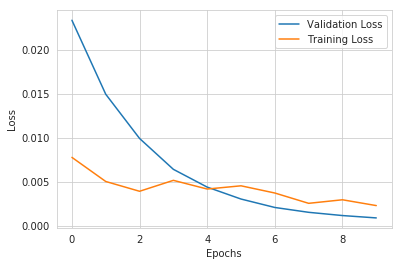

<Figure size 432x288 with 0 Axes>

In [54]:
plt.plot(h['val_loss'],label="Validation Loss")
plt.plot(h['loss'],label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('loss.png')

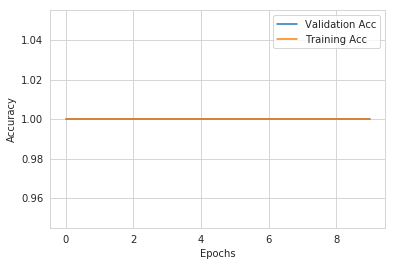

<Figure size 432x288 with 0 Axes>

In [55]:
plt.plot(h['val_accuracy'],label="Validation Acc")
plt.plot(h['accuracy'],label="Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig('acc.png')